In [91]:
import numpy as np
import pandas as pd
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from scipy.stats import gaussian_kde
import shelve

import seaborn as sns
import matplotlib.pyplot as plt
import warnings
%matplotlib inline
sns.set()
warnings.filterwarnings('ignore')

In [92]:
def shelf_read(filename):

    my_shelf = shelve.open(filename)
    for key in my_shelf:
        print(key)
        globals()[key]=my_shelf[key]
    my_shelf.close()

def abline(slope, intercept, ax):
    """Plot a line from slope and intercept"""
    axes = ax
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    ax.plot(x_vals, y_vals, '--', color='black')
    
def RMSE_KFold(model, X, y):
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
    scores = np.absolute(scores)
    print('Mean RMSE: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))
    return np.mean(scores), np.std(scores)

def SVR_Ridge_Lasso_LassoCV(X,y,ofp):
    test_size = 0.33
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
   
    # SVR model
    print('Fitting SVR models...')
    #model_SVR = SVR(kernel='rbf')
    #model_SVR.fit(X_train, y_train)
    
    grid_SVR = GridSearchCV(SVR(), param_grid, refit=True, verbose=3, n_jobs=-1, cv=5, scoring='neg_mean_squared_error')
    grid_SVR.fit(X_train,y_train)
       
    # Ridge model
    params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
     0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
     4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100]}
    folds = 5
    ridge = Ridge()
    model_cv_r = GridSearchCV(estimator = ridge, 
                            param_grid = params, 
                            scoring= 'neg_mean_absolute_error', 
                            refit=True,
                            cv = folds, 
                            return_train_score=True,
                            verbose = 0)            
    model_cv_r.fit(X_train, y_train)
    alpha = model_cv_r.best_params_['alpha']
    model_Ridge = Ridge(alpha=alpha)
    model_Ridge.fit(X_train, y_train)
    
    # Lasso model
    params = {'alpha': [0.00005, 0.0001, 0.001, 0.008, 0.01]}
    folds = 5
    lasso = Lasso()
    model_cv_l = GridSearchCV(estimator = lasso, 
                            param_grid = params, 
                            scoring= 'neg_mean_absolute_error', 
                            refit=True,  
                            cv = folds, 
                            return_train_score=True,
                            verbose = 0)    

    model_cv_l.fit(X_train, y_train)
    alpha = model_cv_l.best_params_['alpha']
    model_Lasso = Lasso(alpha=alpha, copy_X=True, fit_intercept=True, max_iter=1000, normalize=False,
                 positive=False, precompute=False, random_state=42, selection='cyclic',
                 tol=0.0001, warm_start=False)
    model_Lasso.fit(X_train, y_train)
    
    # LassoCV model
    model_LassoCV = LassoCV(cv=5) 
    model_LassoCV.fit(X_train, y_train)
   
    #ElasticNetCV model
    #model_ENet = ElasticNetCV(n_alphas=100, l1_ratio=1.2, random_state=43, normalize=True, cv=5)
    #model_ENet.fit(X_train, y_train)

    #print('Calculating RMSE...')
    #RMSE     = np.empty([4,])
    #RMSE_std = np.empty([4,])
    
    #RMSE[0], RMSE_std[0] = RMSE_KFold(model_SVR, X, y)
    #RMSE[1], RMSE_std[1] = RMSE_KFold(model_Ridge, X, y)
    #RMSE[2], RMSE_std[2] = RMSE_KFold(model_Lasso, X, y)
    #RMSE[3], RMSE_std[3] = RMSE_KFold(model_LassoCV, X, y)
    #RMSE[4], RMSE_std[4] = RMSE_KFold(model_ENet, X, y)
    
    print('Predicting y_pred...')
    y_pred_SVR     = grid_SVR.predict(X_test) 
    y_pred_Ridge   = model_Ridge.predict(X_test) 
    y_pred_Lasso   = model_Lasso.predict(X_test) 
    y_pred_LassoCV = model_LassoCV.predict(X_test) 
    #y_pred_ENet    = model_ENet.predict(X_test) 
    all_pred = np.array([[y_pred_SVR], [y_pred_Ridge], [y_pred_Lasso], [y_pred_LassoCV]]).reshape(4,len(y_pred_SVR))
    
    # Fit the model with the full data
    #model_SVR.fit(X, y)
    #model_Ridge.fit(X, y)
    #model_Lasso.fit(X, y)
    #model_LassoCV.fit(X, y)
    
    print('Saving data...')
    filename = ofp + '_SVR_Ridge_Lasso.out'
    my_shelf = shelve.open(filename, 'n')
    #my_shelf['model_SVR']     = model_SVR
    my_shelf['grid_SVR']      = grid_SVR
    my_shelf['model_Ridge']   = model_Ridge
    my_shelf['model_Lasso']   = model_Lasso
    my_shelf['model_LassoCV'] = model_LassoCV
    #my_shelf['model_ENet']    = model_ENet
    #my_shelf['RMSE']          = RMSE 
    #my_shelf['RMSE_std']      = RMSE_std
    my_shelf['all_pred']      = all_pred
    my_shelf['X_test']        = X_test
    my_shelf['y_test']        = y_test
    my_shelf.close()
    
    print('Done')

In [93]:
pr_file   = "/home/hyung/Lab/data/DL_Error/predictors.csv"
res_file  = "/home/hyung/Lab/data/DL_Error/responses.csv"
pr_data   = pd.read_csv(pr_file)
res_data  = pd.read_csv(res_file)

# Rainf_f/Precip/SWdown_min have some issue because they are all zeros
pr_data.drop(columns=['Rainf_min', 'Rainf_f_min', 'Rainf_f_max','Rainf_f_tavg', 'TotalPrecip_min'], inplace=True)
pr_data.drop(columns=['Evap_min', 'Evap_max', 'Evap_tavg'], inplace=True)
pr_data.drop(columns=['LWdown_f_max', 'LWdown_f_min', 'LWdown_f_tavg'], inplace=True)
pr_data.drop(columns=['Qair_f_max',	'Qair_f_min', 'Qh_max',	'Qh_min'], inplace=True)
pr_data.drop(columns=['Qle_min', 'Qle_max', 'Qle_tavg'], inplace=True)
pr_data.drop(columns=['SWdown_f_min', 'SWdown_f_max', 'SWdown_f_tavg'], inplace=True)
pr_data.drop(columns=['SMOS_RFI_min', 'SoilMoist_max', 'SoilMoist_min',	'SoilMoist_tavg'], inplace=True)
pr_data.drop(columns=['Tair_f_max', 'Tair_f_min', 'Tair_f_tavg', 'aspect'], inplace=True)
pr_data.drop(columns=['Wind_f_max',	'Wind_f_min', 'Wind_f_tavg'], inplace=True)
pr_data.drop(columns=['LAI_min', 'LAI_max','Greenness_min', 'Greenness_max', 'AvgSurfT_min', 'AvgSurfT_max'],inplace=True)
pr_data.drop(columns=['SoilTemp_min', 'SoilTemp_max','RadT_min', 'RadT_max'],inplace=True)
pr_data.drop(columns=['SMAP_vo_min', 'SMAP_vo_max','SMAP_rc_min', 'SMAP_rc_max'],inplace=True)
pr_data.drop(columns=['albedo_max', 'albedo_min','albedo_std', 'TotalPrecip_max','Rainf_max','SMOS_RFI_max'],inplace=True)

#Group the data using RFI values
nog = 10
RFI_tavg = pr_data['SMOS_RFI_tavg'].dropna(axis=0, how='any')
RFI_p = np.empty(nog, dtype=object)
for i in range(1,nog+1):
    RFI_p[i-1] = np.percentile(RFI_tavg, i*100/nog)

RFI_class = np.copy(pr_data['SMOS_RFI_tavg'])

for i in range(0,nog):
    if i > 0:
        RFI_class[(pr_data['SMOS_RFI_tavg'] > RFI_p[i-1]) & (pr_data['SMOS_RFI_tavg'] <= RFI_p[i])]=i
    elif i == 0:
        RFI_class[(pr_data['SMOS_RFI_tavg'] <= RFI_p[i])]=i
pr_data['RFI_class'] = RFI_class

# TC estimations with std value larger than 0.2 might be unstable
std_thred     = 0.1
mask_std_A2   = (res_data['AMSR2_std'] <= std_thred) & (pr_data.ltype!=21) & (pr_data.ltype!=17)
mask_std_AS   = (res_data['ASCAT_std'] <= std_thred) & (pr_data.ltype!=21) & (pr_data.ltype!=17)
mask_std_SMOS = (res_data['SMOS_std'] <= std_thred) & (pr_data.ltype!=21) & (pr_data.ltype!=17)
mask_std_SMAP = (res_data['SMAP_std'] <= std_thred) & (pr_data.ltype!=21) & (pr_data.ltype!=17)

# 2 clean the data sets
selected_predictors = list(pr_data.columns.values)

sel_A2   = selected_predictors.copy()
sel_A2.append('AMSR2_fMSE')
sel_AS   = selected_predictors.copy()
sel_AS.append('ASCAT_fMSE')
sel_SMOS = selected_predictors.copy()
sel_SMOS.append('SMOS_fMSE')
sel_SMAP = selected_predictors.copy()
sel_SMAP.append('SMAP_fMSE')

A2_fMSE   = pr_data.join(res_data['AMSR2_fMSE'])[sel_A2]
AS_fMSE   = pr_data.join(res_data['ASCAT_fMSE'])[sel_AS]
SMOS_fMSE = pr_data.join(res_data['SMOS_fMSE'])[sel_SMOS]
SMAP_fMSE = pr_data.join(res_data['SMAP_fMSE'])[sel_SMAP]

# select fMSE <= threshold
A2_fMSE   = A2_fMSE[mask_std_A2]
AS_fMSE   = AS_fMSE[mask_std_AS]
SMOS_fMSE = SMOS_fMSE[mask_std_SMOS]
SMAP_fMSE = SMAP_fMSE[mask_std_SMAP]
                      
# drop N/A
A2_fMSE.dropna(axis=0, how='any', inplace=True)
AS_fMSE.dropna(axis=0, how='any', inplace=True)
SMOS_fMSE.dropna(axis=0, how='any', inplace=True)
SMAP_fMSE.dropna(axis=0, how='any', inplace=True)

# Numeric, categorical predictors and response, y`
# AMSR2
A2_num   = A2_fMSE.drop(columns=['ltype', 'RFI_class', 'AMSR2_fMSE'])
A2_cat   = A2_fMSE['ltype']
A2_RFI   = A2_fMSE['RFI_class']
A2_y     = A2_fMSE['AMSR2_fMSE']
# ASCAT
AS_num   = AS_fMSE.drop(columns=['ltype', 'RFI_class', 'ASCAT_fMSE'])
AS_cat   = AS_fMSE['ltype']
AS_RFI   = AS_fMSE['RFI_class']
AS_y     = AS_fMSE['ASCAT_fMSE']
# SMOS
SMOS_num = SMOS_fMSE.drop(columns=['ltype', 'RFI_class', 'SMOS_fMSE'])
SMOS_cat = SMOS_fMSE['ltype']
SMOS_RFI = SMOS_fMSE['RFI_class']
SMOS_y   = SMOS_fMSE['SMOS_fMSE']
# SMAP
SMAP_num = SMAP_fMSE.drop(columns=['ltype', 'RFI_class', 'SMAP_fMSE'])
SMAP_cat = SMAP_fMSE['ltype']
SMAP_RFI = SMAP_fMSE['RFI_class']
SMAP_y   = SMAP_fMSE['SMAP_fMSE']

all_predictors = SMAP_num.columns.values

# Standardize numeric/response columns, to mean 0 variance 1
# AMSR2
A2_mean       = A2_num.mean()
A2_std        = A2_num.std()
A2_num_scaled = np.array((A2_num - A2_mean) / A2_std)
A2_y_mean     = A2_y.mean()
A2_y_std      = A2_y.std()
A2_y_scaled   = np.array((A2_y - A2_y_mean) / A2_y_std)
# ASCAT
AS_mean       = AS_num.mean()
AS_std        = AS_num.std()
AS_num_scaled = np.array((AS_num - AS_mean) / AS_std)
AS_y_mean     = AS_y.mean()
AS_y_std      = AS_y.std()
AS_y_scaled   = np.array((AS_y - AS_y_mean) / AS_y_std)
# SMOS
SMOS_mean       = SMOS_num.mean()
SMOS_std        = SMOS_num.std()
SMOS_num_scaled = np.array((SMOS_num - SMOS_mean) / SMOS_std)
SMOS_y_mean     = SMOS_y.mean()
SMOS_y_std      = SMOS_y.std()
SMOS_y_scaled   = np.array((SMOS_y - SMOS_y_mean) / SMOS_y_std)
# SMAP
SMAP_mean        = SMAP_num.mean()
SMAP_std         = SMAP_num.std()
SMAP_num_scaled  = np.array((SMAP_num - SMAP_mean) / SMAP_std)
SMAP_y_mean      = SMAP_y.mean()
SMAP_y_std       = SMAP_y.std()
SMAP_y_scaled    = np.array((SMAP_y - SMAP_y_mean) / SMAP_y_std)

In [ ]:
product_list = ['SMAP', 'SMOS', 'AS', 'A2']

for i in range(0,1):
    product = product_list[i]
    print(product)
    exec('X = '+product+'_num_scaled')
    exec('y = '+product+'_y')
    ofp = '/home/hyung/Lab/libs/python/DL_Error_data/'+product
    SVR_Ridge_Lasso_LassoCV(X,y, ofp)

SMAP
Fitting SVR models...
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 128 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    2.4s


SMAP
grid_SVR


UnpicklingError: pickle data was truncated

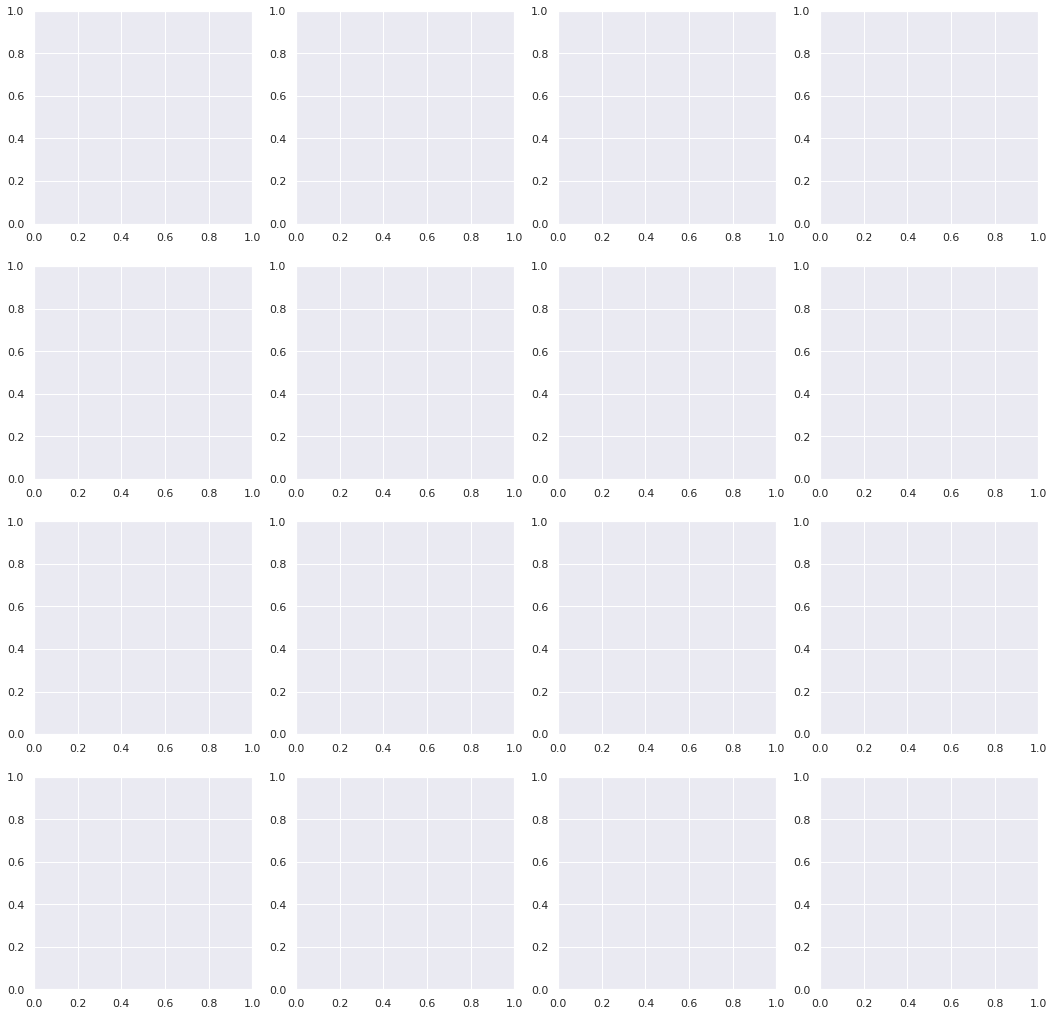

In [90]:
# plot the resutls
product_list = ['SMAP', 'SMOS', 'AS', 'A2']
fig, ax = plt.subplots(nrows=4, ncols=4)
fig.set_size_inches(18,18)
k = 0
for j in range(0,4):
    product = product_list[j]

    print(product)
    ofp = '/home/hyung/Lab/libs/python/DL_Error_data/'+product
    shelf_read(ofp+'_SVR_Ridge_Lasso.out')

    model_list = ['SVR', 'Ridge', 'Lasso', 'LassoCV']
    for i in range(0,4):
        y_pred = all_pred[i,:]
        xy = np.vstack([y_pred, y_test])
        z = gaussian_kde(xy)(xy)
        ax = ax.flatten()
        
        ax[k].scatter(y_pred, y_test, c=z, s=2, cmap='RdYlBu_r')
        ax[k].set_xlabel('Predicted $\it{fMSE}$', size=15)
        ax[k].set_ylabel("True $\it{fMSE}$", size=15)

        ax[k].set_xticks(np.arange(0,1.2,0.2))
        ax[k].set_yticks(np.arange(0,1.2,0.2))
        plt.setp(ax[k].spines.values(), color='k')
        ax[k].grid(b=True, which='major', color='grey', linestyle='--')
        ax[k].set_ylim(0,1)
        ax[k].set_xlim(0,1)
        ax[k].set_facecolor("white")
        ax[k].set_aspect('equal')
        RMSE = mean_squared_error(y_test, y_pred, squared=False) 
        ax[k].set_title(product+'/'+model_list[i]+f' RMSE: {RMSE: .3f}', size=15, fontweight='bold')
        abline(1,0, ax[k])
        k = k +1
    fig.tight_layout()
    #plt.show()

<AxesSubplot:title={'center':'A2/SVR RMSE:  0.094'}, xlabel='Predicted $\\it{fMSE}$', ylabel='True $\\it{fMSE}$'>

In [44]:
# Test code lines
test_size = 0.33
X = SMOS_num_scaled[:500,]
y = SMOS_y[:500,]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

#model_SVR = SVR(kernel='rbf')
#model_SVR.fit(X_train, y_train)

param_grid = {'C': [500, 700, 1000],
             'epsilon': [0.0001, 0.001, 0.01, 0.1, 1, 10],
             'gamma': [0.001, 0.01, 0.1, 1],
             'kernel':['rbf']
            }

#grid = GridSearchCV(estimator = SVR(),
#                    param_grid = param_grid,
#                    cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)

grid = GridSearchCV(SVR(), param_grid, refit=True, verbose=3, n_jobs=-1, cv=3, scoring='neg_mean_squared_error')
grid.fit(X_train,y_train)
grid_predictions = grid.predict(X_test)

y_pred = grid_predictions 
xy = np.vstack([y_pred, y_test])
z = gaussian_kde(xy)(xy)
i=0
#ax = ax.flatten()
plt.scatter(y_pred, y_test, c=z, s=2, cmap='RdYlBu_r')
#plt.scatter(1,1)
#ax[i].set_title(product+'/'+model_list[i]+f' RMSE: {RMSE[i]: .3f} ({RMSE_std[i]:.4f})', size=15, fontweight='bold')
#abline(1,0, ax[i])

In [53]:
model_ENet = ElasticNetCV(n_alphas=100, l1_ratio=1.2, random_state=43, normalize=True, cv=5)
model_ENet.fit(X_train, y_train)
y_pred_ENet = model_ENet.predict(X_train)
mean_squared_error(y_pred_ENet, y_train)**0.5

0.12608858661789832